In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Librerías para mapas
try:
    import geopandas as gpd
    import plotly.express as px
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("⚠️ plotly/geopandas no disponibles. Instalar con: pip install geopandas plotly")

warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("Librerías importadas correctamente ✓")

Librerías importadas correctamente ✓


## 1. Cargar Datos

In [3]:
# Cargar datos
df_eph = pd.read_parquet("../datos/processed/eph_consolidado.parquet")
print(f"Dataset cargado: {df_eph.shape}")

Dataset cargado: (987193, 251)


## 2. Calcular Indicadores por Aglomerado

In [ ]:
# Verificar si existe la columna de aglomerado
if 'AGLOMERADO' not in df_eph.columns:
    print("⚠️ La columna AGLOMERADO no está disponible en el dataset")
    print("No se podrán generar visualizaciones georreferenciadas.")
else:
    # Filtrar población en edad de trabajar
    df_pet = df_eph[df_eph['CH06'] >= 10].copy()
    
    # Filtrar solo CABA (32) y Mar del Plata (34)
    aglomerados_seleccionados = [32, 34]
    df_pet = df_pet[df_pet['AGLOMERADO'].isin(aglomerados_seleccionados)].copy()
    
    # Usar el último período disponible para el análisis
    ultimo_periodo = df_pet['periodo'].max()
    print(f"Período de análisis: {ultimo_periodo}")
    print(f"Aglomerados analizados: CABA (32) y Mar del Plata (34)")
    
    df_analisis = df_pet[df_pet['periodo'] == ultimo_periodo].copy()
    
    # Calcular tasas por aglomerado
    tasas_aglomerado = []
    
    for aglom in aglomerados_seleccionados:
        df_aglom = df_analisis[df_analisis['AGLOMERADO'] == aglom]
        
        pet = df_aglom['PONDERA'].sum()
        pea = df_aglom[df_aglom['es_pea']]['PONDERA'].sum()
        ocupados = df_aglom[df_aglom['es_ocupado']]['PONDERA'].sum()
        desocupados = df_aglom[df_aglom['es_desocupado']]['PONDERA'].sum()
        
        tasas_aglomerado.append({
            'aglomerado': aglom,
            'tasa_actividad': (pea / pet) * 100 if pet > 0 else 0,
            'tasa_empleo': (ocupados / pet) * 100 if pet > 0 else 0,
            'tasa_desocupacion': (desocupados / pea) * 100 if pea > 0 else 0,
            'poblacion': pet
        })
    

    df_tasas_aglom = pd.DataFrame(tasas_aglomerado)    print(df_tasas_aglom.head(10))

    print("\nPrimeros registros:")
    print(f"\nIndicadores calculados para {len(df_tasas_aglom)} aglomerados")

Período de análisis: 2025-T2

Indicadores calculados para 32 aglomerados

Primeros registros:
   aglomerado  tasa_actividad  tasa_empleo  tasa_desocupacion  poblacion
0          32           61.04        58.43               4.26    2687249
1          26           53.60        51.36               4.17     216653
2           2           53.94        50.21               6.91     830073
3           7           52.60        50.32               4.34     344570
4          27           51.57        50.01               3.02     481289
5           4           59.47        54.89               7.71    1208757
6          31           57.55        52.80               8.26     158451
7          14           45.75        43.29               5.38     142038
8          19           56.32        54.36               3.48     317027
9           6           52.52        49.59               5.57     254905


## 3. Mapeo de Códigos de Aglomerado a Nombres

In [ ]:
# Diccionario de códigos de aglomerados seleccionados para análisis
# CABA y Mar del Plata
aglomerados_nombres = {
    32: 'Ciudad de Buenos Aires (CABA)',
    34: 'Mar del Plata'
}

# Agregar nombres al DataFrame
if 'AGLOMERADO' in df_eph.columns:
    df_tasas_aglom['nombre_aglomerado'] = df_tasas_aglom['aglomerado'].map(aglomerados_nombres)
    
    # Para aglomerados sin nombre, usar el código
    df_tasas_aglom['nombre_aglomerado'] = df_tasas_aglom['nombre_aglomerado'].fillna(
        'Aglomerado ' + df_tasas_aglom['aglomerado'].astype(str)
    )
    
    print("Nombres de aglomerados agregados ✓")

Nombres de aglomerados agregados ✓


## 4. Visualización: Gráfico de Barras por Aglomerado

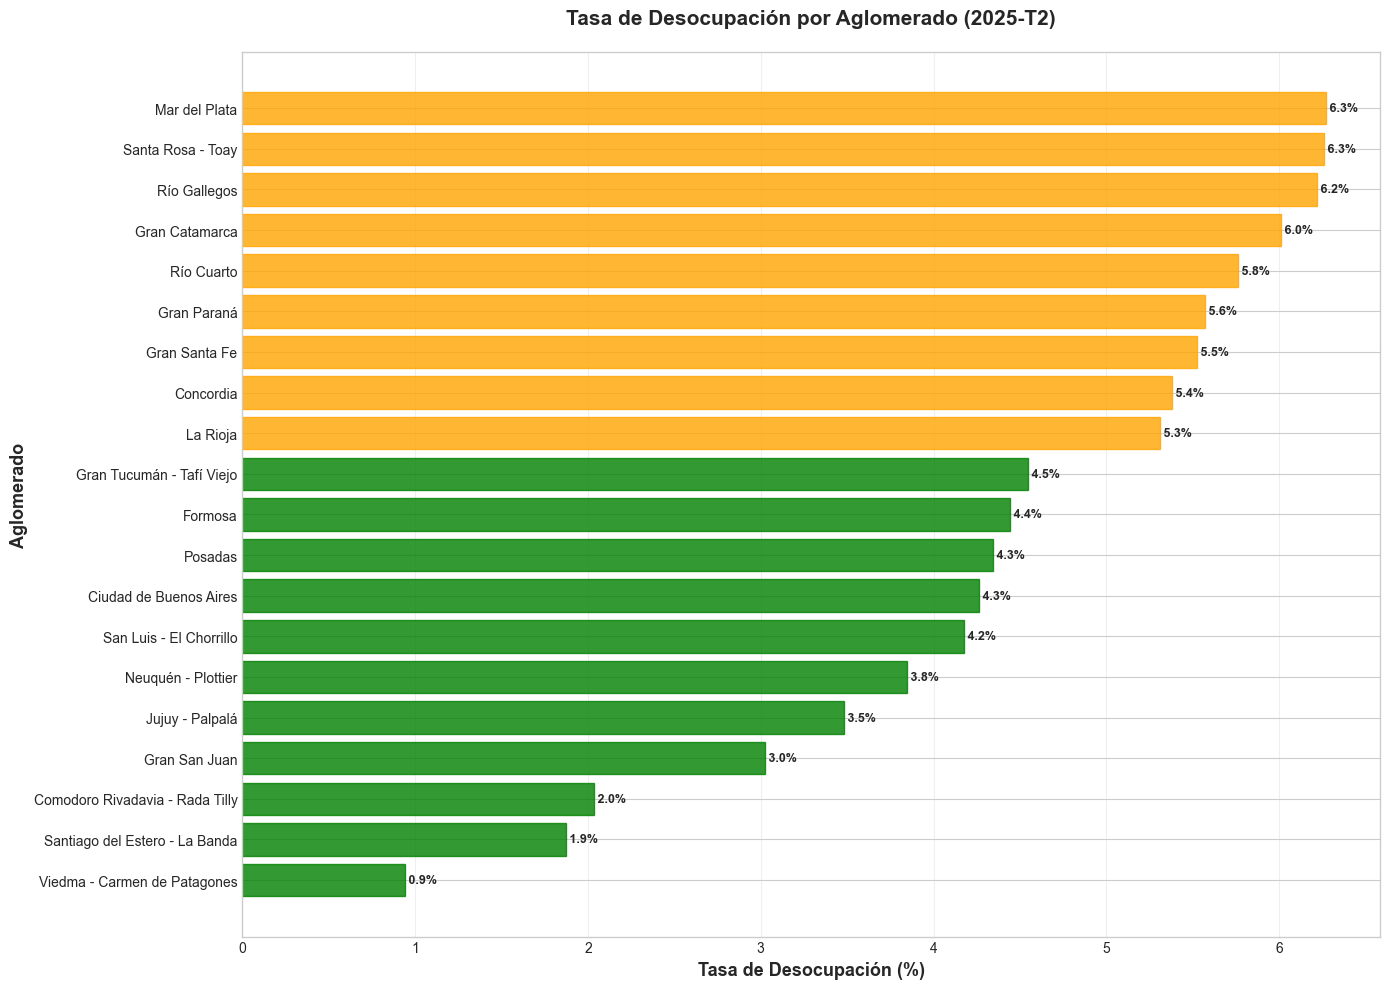

✓ Gráfico guardado: desocupacion_por_aglomerado.png


In [ ]:
if 'AGLOMERADO' in df_eph.columns:
    # Ordenar por tasa de desocupación
    df_plot = df_tasas_aglom.sort_values('tasa_desocupacion', ascending=True)
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    bars = ax.barh(df_plot['nombre_aglomerado'], df_plot['tasa_desocupacion'], 
                   color='steelblue', alpha=0.8)
    
    # Colorear según nivel de desocupación
    colors = ['green' if val < 5 else 'orange' if val < 10 else 'red' 
             for val in df_plot['tasa_desocupacion']]
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    ax.set_xlabel('Tasa de Desocupación (%)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Aglomerado', fontsize=13, fontweight='bold')
    ax.set_title(f'Tasa de Desocupación por Aglomerado ({ultimo_periodo})', 
                fontsize=15, fontweight='bold', pad=20)
    
    # Agregar valores en las barras
    for i, (idx, row) in enumerate(df_plot.iterrows()):
        ax.text(row['tasa_desocupacion'], i, f" {row['tasa_desocupacion']:.1f}%", 
               va='center', fontsize=9, fontweight='bold')
    
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    
    plt.savefig('../resultados/graficos/desocupacion_por_aglomerado.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Gráfico guardado: desocupacion_por_aglomerado.png")

## 5. Coordenadas Geográficas de Aglomerados (Aproximadas)

In [8]:
# Coordenadas aproximadas de los principales aglomerados
coordenadas_aglomerados = {
    2: (-34.9214, -57.9544),   # Gran La Plata
    3: (-38.7183, -62.2663),   # Bahía Blanca
    4: (-32.9442, -60.6505),   # Gran Rosario
    5: (-31.6333, -60.7),      # Gran Santa Fe
    6: (-31.7333, -60.5297),   # Gran Paraná
    7: (-27.3671, -55.8961),   # Posadas
    8: (-27.4514, -58.9867),   # Gran Resistencia
    9: (-45.8667, -67.5),      # Comodoro Rivadavia
    10: (-32.8908, -68.8272),  # Gran Mendoza
    12: (-27.4692, -58.8306),  # Corrientes
    13: (-31.4201, -64.1888),  # Gran Córdoba
    14: (-31.3933, -58.0211),  # Concordia
    15: (-26.1775, -58.1781),  # Formosa
    17: (-38.9516, -68.0591),  # Neuquén
    18: (-27.7833, -64.2667),  # Santiago del Estero
    19: (-24.1858, -65.2995),  # Jujuy
    20: (-51.6230, -69.2168),  # Río Gallegos
    22: (-28.4696, -65.7795),  # Gran Catamarca
    23: (-24.7859, -65.4117),  # Salta
    25: (-29.4131, -66.8558),  # La Rioja
    26: (-33.3017, -66.3378),  # San Luis
    27: (-31.5375, -68.5364),  # Gran San Juan
    29: (-26.8083, -65.2176),  # Gran Tucumán
    30: (-36.6167, -64.2833),  # Santa Rosa
    31: (-54.8019, -68.3029),  # Ushuaia
    32: (-34.6037, -58.3816),  # CABA
    33: (-34.6037, -58.5816),  # GBA
    34: (-38.0055, -57.5426),  # Mar del Plata
    36: (-33.1301, -64.3499),  # Río Cuarto
    38: (-33.3356, -60.2128),  # San Nicolás
    91: (-43.3002, -65.1023),  # Rawson-Trelew
    93: (-40.8135, -62.9967)   # Viedma
}

# Agregar coordenadas al DataFrame
if 'AGLOMERADO' in df_eph.columns:
    df_tasas_aglom['lat'] = df_tasas_aglom['aglomerado'].map(lambda x: coordenadas_aglomerados.get(x, (None, None))[0])
    df_tasas_aglom['lon'] = df_tasas_aglom['aglomerado'].map(lambda x: coordenadas_aglomerados.get(x, (None, None))[1])
    
    # Filtrar solo aglomerados con coordenadas
    df_tasas_aglom_geo = df_tasas_aglom[df_tasas_aglom['lat'].notna()].copy()
    
    print(f"Aglomerados con coordenadas: {len(df_tasas_aglom_geo)}")

Aglomerados con coordenadas: 32


## 6. Mapa de Puntos: Tasa de Desocupación

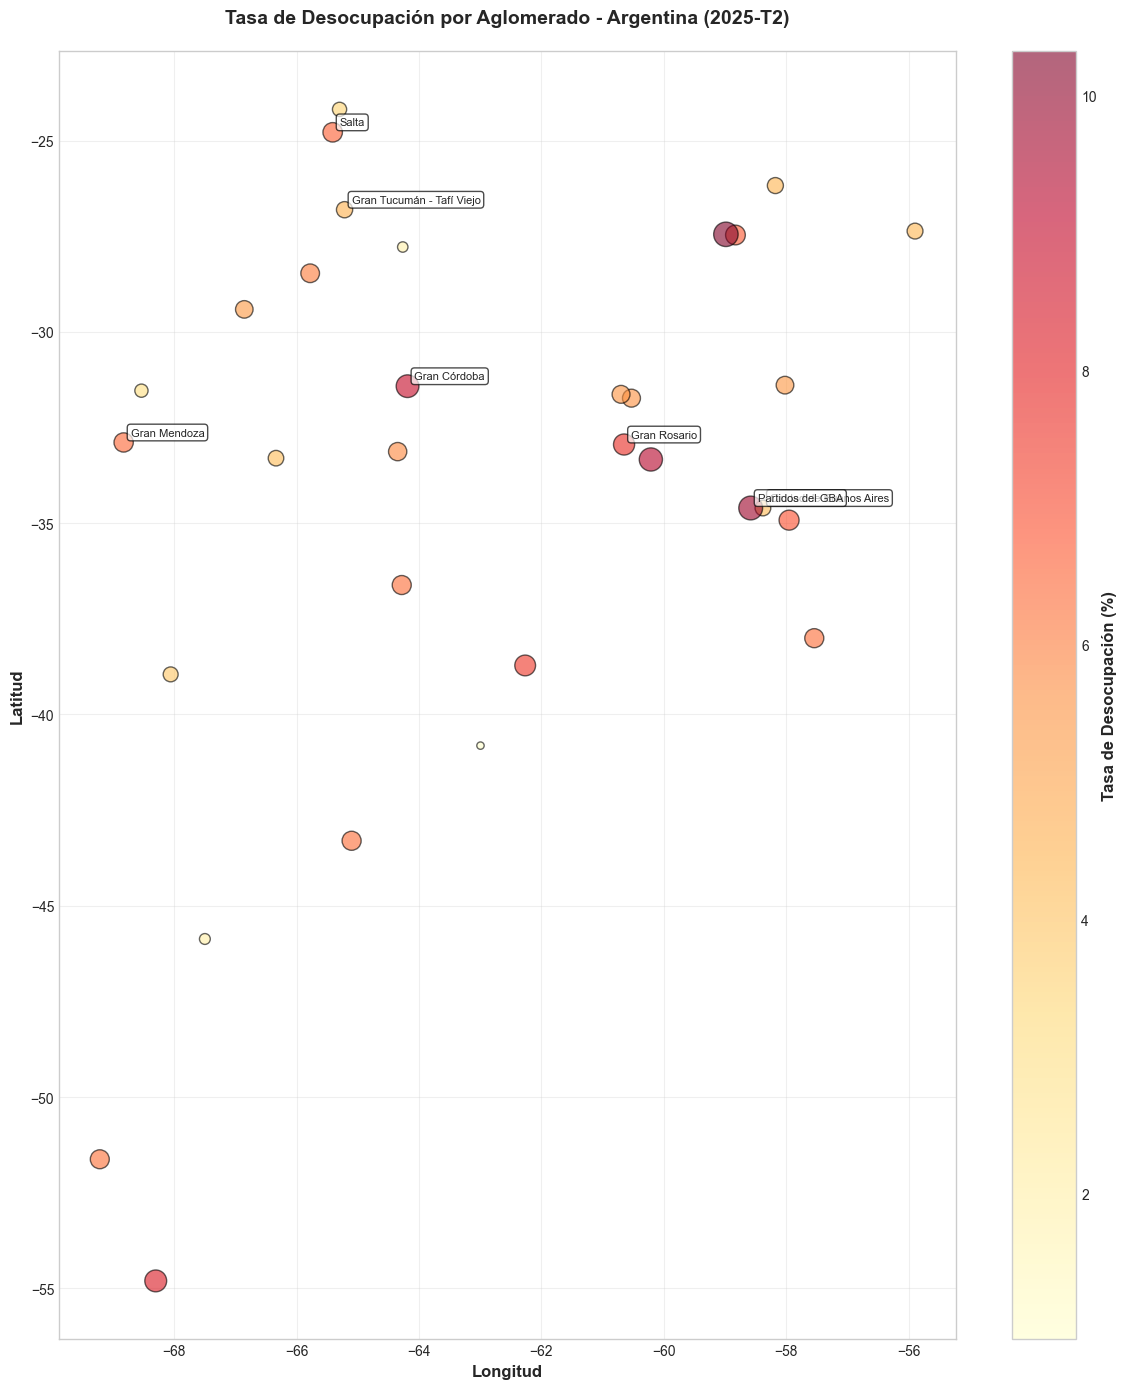

✓ Gráfico guardado: mapa_desocupacion_argentina.png


In [9]:
if 'AGLOMERADO' in df_eph.columns and len(df_tasas_aglom_geo) > 0:
    fig, ax = plt.subplots(figsize=(12, 14))
    
    # Mapa de dispersión con tamaño proporcional a la tasa
    scatter = ax.scatter(
        df_tasas_aglom_geo['lon'], 
        df_tasas_aglom_geo['lat'],
        s=df_tasas_aglom_geo['tasa_desocupacion'] * 30,  # Tamaño
        c=df_tasas_aglom_geo['tasa_desocupacion'],       # Color
        cmap='YlOrRd',
        alpha=0.6,
        edgecolors='black',
        linewidth=1
    )
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Tasa de Desocupación (%)', fontsize=12, fontweight='bold')
    
    ax.set_xlabel('Longitud', fontsize=12, fontweight='bold')
    ax.set_ylabel('Latitud', fontsize=12, fontweight='bold')
    ax.set_title(f'Tasa de Desocupación por Aglomerado - Argentina ({ultimo_periodo})', 
                fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3)
    
    # Agregar nombres de algunos aglomerados principales
    aglomerados_destacados = [32, 33, 13, 4, 10, 29, 23]  # CABA, GBA, Córdoba, Rosario, Mendoza, Tucumán, Salta
    for idx, row in df_tasas_aglom_geo.iterrows():
        if row['aglomerado'] in aglomerados_destacados:
            ax.annotate(
                row['nombre_aglomerado'],
                xy=(row['lon'], row['lat']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
            )
    
    plt.tight_layout()
    plt.savefig('../resultados/graficos/mapa_desocupacion_argentina.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Gráfico guardado: mapa_desocupacion_argentina.png")

## 7. Mapa Interactivo con Plotly (Opcional)

✓ Mapa interactivo guardado: mapa_interactivo_desocupacion.html


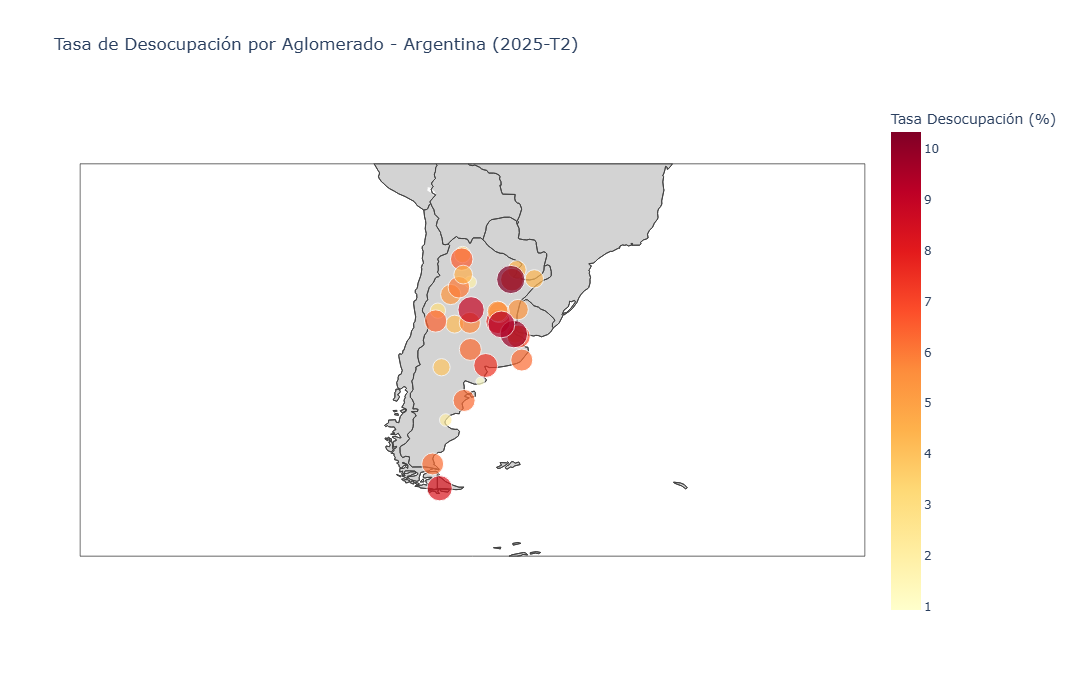

In [10]:
if PLOTLY_AVAILABLE and 'AGLOMERADO' in df_eph.columns and len(df_tasas_aglom_geo) > 0:
    
    # Crear mapa interactivo
    fig = px.scatter_geo(
        df_tasas_aglom_geo,
        lat='lat',
        lon='lon',
        color='tasa_desocupacion',
        size='tasa_desocupacion',
        hover_name='nombre_aglomerado',
        hover_data={
            'tasa_desocupacion': ':.2f',
            'tasa_empleo': ':.2f',
            'tasa_actividad': ':.2f',
            'lat': False,
            'lon': False
        },
        color_continuous_scale='YlOrRd',
        title=f'Tasa de Desocupación por Aglomerado - Argentina ({ultimo_periodo})',
        labels={'tasa_desocupacion': 'Tasa Desocupación (%)'}
    )
    
    # Centrar en Argentina
    fig.update_geos(
        center=dict(lat=-38, lon=-64),
        projection_scale=3.5,
        showcountries=True,
        showcoastlines=True,
        showland=True,
        landcolor='lightgray'
    )
    
    fig.update_layout(
        height=700,
        font=dict(size=12)
    )
    
    # Guardar como HTML
    fig.write_html('../resultados/graficos/mapa_interactivo_desocupacion.html')
    print("✓ Mapa interactivo guardado: mapa_interactivo_desocupacion.html")
    
    # Mostrar en el notebook
    fig.show()
    
elif not PLOTLY_AVAILABLE:
    print("⚠️ Plotly no está instalado. Instalar con: pip install plotly")
else:
    print("⚠️ No hay datos de aglomerados disponibles")

## 8. Heatmap de Indicadores por Aglomerado

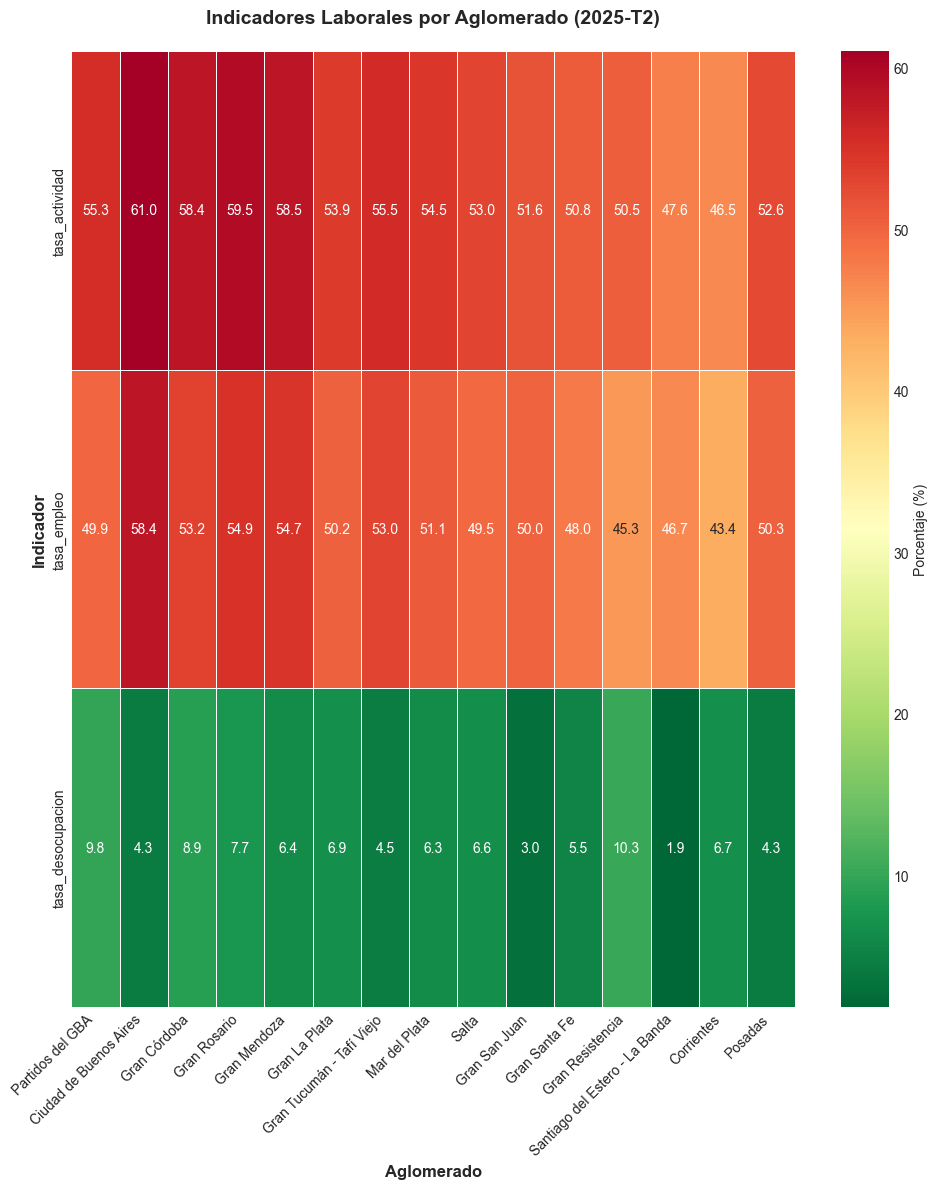

✓ Gráfico guardado: heatmap_indicadores_aglomerado.png


In [ ]:
if 'AGLOMERADO' in df_eph.columns:
    # Usar ambos aglomerados seleccionados
    df_top = df_tasas_aglom.copy()
    
    # Preparar datos para heatmap
    df_heatmap = df_top[['nombre_aglomerado', 'tasa_actividad', 'tasa_empleo', 'tasa_desocupacion']].set_index('nombre_aglomerado')
    
    # Crear heatmap
    fig, ax = plt.subplots(figsize=(10, 12))
    
    sns.heatmap(
        df_heatmap.T,
        annot=True,
        fmt='.1f',
        cmap='RdYlGn_r',
        cbar_kws={'label': 'Porcentaje (%)'},
        linewidths=0.5,
        ax=ax
    )
    
    ax.set_xlabel('Aglomerado', fontsize=12, fontweight='bold')
    ax.set_ylabel('Indicador', fontsize=12, fontweight='bold')
    ax.set_title(f'Indicadores Laborales por Aglomerado ({ultimo_periodo})', 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    plt.savefig('../resultados/graficos/heatmap_indicadores_aglomerado.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Gráfico guardado: heatmap_indicadores_aglomerado.png")

## 9. Guardar Resultados

In [12]:
if 'AGLOMERADO' in df_eph.columns:
    # Guardar tabla de tasas por aglomerado
    df_tasas_aglom.to_csv('../resultados/tablas/tasas_por_aglomerado.csv', index=False)
    print("✓ Tabla guardada: tasas_por_aglomerado.csv")
    
    # Guardar tabla con coordenadas
    if len(df_tasas_aglom_geo) > 0:
        df_tasas_aglom_geo.to_csv('../resultados/tablas/tasas_aglomerado_geocodificado.csv', index=False)
        print("✓ Tabla guardada: tasas_aglomerado_geocodificado.csv")

✓ Tabla guardada: tasas_por_aglomerado.csv
✓ Tabla guardada: tasas_aglomerado_geocodificado.csv


## 10. Resumen

In [13]:
if 'AGLOMERADO' in df_eph.columns:
    print("="*70)
    print("RESUMEN DE VISUALIZACIONES GEORREFERENCIADAS")
    print("="*70)
    
    print(f"\nPeríodo analizado: {ultimo_periodo}")
    print(f"Total de aglomerados: {len(df_tasas_aglom)}")
    print(f"Aglomerados geocodificados: {len(df_tasas_aglom_geo)}")
    
    print("\nAglomerado con mayor desocupación:")
    max_idx = df_tasas_aglom['tasa_desocupacion'].idxmax()
    print(f"  {df_tasas_aglom.loc[max_idx, 'nombre_aglomerado']}: {df_tasas_aglom.loc[max_idx, 'tasa_desocupacion']:.2f}%")
    
    print("\nAglomerado con menor desocupación:")
    min_idx = df_tasas_aglom['tasa_desocupacion'].idxmin()
    print(f"  {df_tasas_aglom.loc[min_idx, 'nombre_aglomerado']}: {df_tasas_aglom.loc[min_idx, 'tasa_desocupacion']:.2f}%")
    
    print(f"\n{'='*70}")
    print("Visualizaciones georreferenciadas completadas ✓")
    print(f"{'='*70}")
else:
    print("⚠️ No se pudo generar análisis georreferenciado: columna AGLOMERADO no disponible")

RESUMEN DE VISUALIZACIONES GEORREFERENCIADAS

Período analizado: 2025-T2
Total de aglomerados: 32
Aglomerados geocodificados: 32

Aglomerado con mayor desocupación:
  Gran Resistencia: 10.33%

Aglomerado con menor desocupación:
  Viedma - Carmen de Patagones: 0.94%

Visualizaciones georreferenciadas completadas ✓
